In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.simulations.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml
%config Completer.use_jedi = False

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 576 results
transitions_data returned 144 results
total_population_data returned 288 results
initialization time:  41.54780983924866
simulation_time:  34.77810621261597
initialization time:  45.309370279312134
simulation_time:  35.10961675643921
initialization time:  46.20304203033447
simulation_time:  39.773744106292725


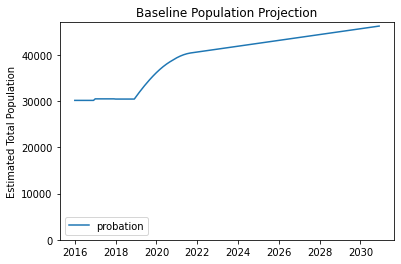

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/IA/IAHSB6_model_inputs.yaml')
test_sim.simulate_baseline(['probation'])

In [8]:
test_sim.data_dict['transitions_data'][test_sim.data_dict['transitions_data'].compartment == 'probation']

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
4,IA_HSB6,34.0,probation,release,0.854000,felony,None,None,None,2021-02-01 00:42:51.288488+00:00
5,IA_HSB6,34.0,probation,release,0.854000,misdemeanor,None,None,None,2021-02-01 00:42:51.288488+00:00
6,IA_HSB6,1.0,probation,prison_crime_revocations,0.002747,felony,None,None,None,2021-02-01 00:42:51.288488+00:00
7,IA_HSB6,2.0,probation,prison_crime_revocations,0.002747,felony,None,None,None,2021-02-01 00:42:51.288488+00:00
8,IA_HSB6,3.0,probation,prison_crime_revocations,0.002747,felony,None,None,None,2021-02-01 00:42:51.288488+00:00
...,...,...,...,...,...,...,...,...,...,...
137,IA_HSB6,30.0,probation,prison_technical_revocations,0.001547,misdemeanor,None,None,None,2021-02-01 00:42:51.288488+00:00
138,IA_HSB6,31.0,probation,prison_technical_revocations,0.001547,misdemeanor,None,None,None,2021-02-01 00:42:51.288488+00:00
139,IA_HSB6,32.0,probation,prison_technical_revocations,0.001547,misdemeanor,None,None,None,2021-02-01 00:42:51.288488+00:00
140,IA_HSB6,33.0,probation,prison_technical_revocations,0.001547,misdemeanor,None,None,None,2021-02-01 00:42:51.288488+00:00


initialization time:  61.10116696357727
simulation_time:  41.151155948638916
initialization time:  56.28906989097595
simulation_time:  40.707643032073975


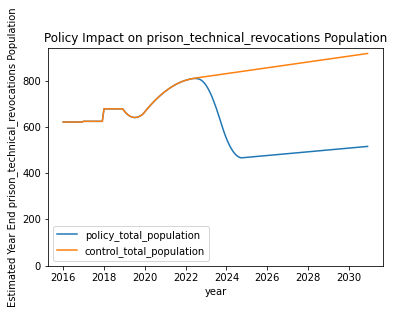

In [8]:
DISCHARGE_CREDITS_REDUCTION = 14 / (14 + 365/12)
EDUCATION_CREDITS_AFFECTED_FRACTION = 0.5
LOS = 34
MINIMUM_PERIODS = {'misdemeanor': 12, 'felony': 24}
SENTENCED_AT_MINIMUM = 0.4


# Policy Option Methods
def apply_education_credits(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_df=pd.DataFrame({'outflow': ['release'], 
                                              'affected_fraction': [EDUCATION_CREDITS_AFFECTED_FRACTION], 
                                              'reduction_size': [90 * 12 / 365]}),
                   reduction_type='+',
                   retroactive=retroactive)

def apply_discharge_credits(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_df=pd.DataFrame({'outflow': ['release'], 'affected_fraction': [1], 
                                              'reduction_size': [DISCHARGE_CREDITS_REDUCTION]}),
                   reduction_type='*',
                   retroactive=retroactive)

def shorten_minimum(crime_type, retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_df=pd.DataFrame({'outflow': ['release'], 'affected_fraction': [1], 
                                              'reduction_size': [(LOS - MINIMUM_PERIODS[crime_type]) * SENTENCED_AT_MINIMUM]}),
                   reduction_type='+',
                   retroactive=retroactive)

def adjust_technical_revocations(retroactive=False):
    return partial(CompartmentTransitions.chop_technical_revocations,
                   technical_outflow='prison_technical_revocations',
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_education_credits(),
                spark_compartment='probation',
                sub_population={'crime': crime_type},
                apply_retroactive=False)
    for crime_type in MINIMUM_PERIODS
] + [
    SparkPolicy(policy_fn=apply_discharge_credits(),
                spark_compartment='probation',
                sub_population={'crime': crime_type},
                apply_retroactive=False)
    for crime_type in MINIMUM_PERIODS
] + [
    SparkPolicy(policy_fn=shorten_minimum(crime_type = crime_type),
                spark_compartment='probation',
                sub_population={'crime': crime_type},
                apply_retroactive=False)
    for crime_type in MINIMUM_PERIODS
] + [
    SparkPolicy(policy_fn=adjust_technical_revocations(),
                spark_compartment='probation',
                sub_population={'crime': crime_type},
                apply_retroactive=False)
    for crime_type in MINIMUM_PERIODS
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison_technical_revocations')


In [9]:
simulation_tag = 'IA_HSB_6_40%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [11]:
test_sim.pop_simulations['baseline_min'].sub_simulations['misdemeanor'].simulation_compartments['probation'].transition_tables.transition_dfs

{'before': outflow_to            prison_crime_revocations  prison_technical_revocations  \
 compartment_duration                                                           
 1                                     0.002747                      0.001547   
 2                                     0.002759                      0.001554   
 3                                     0.002771                      0.001560   
 4                                     0.002783                      0.001567   
 5                                     0.002795                      0.001574   
 6                                     0.002807                      0.001581   
 7                                     0.002820                      0.001588   
 8                                     0.002832                      0.001595   
 9                                     0.002845                      0.001602   
 10                                    0.002857                      0.001609   
 11               

In [6]:
test_sim.output_data['life_years']

,jail,release,prison
year,,,
2016,0.0,0.000000,0.000000
2017,0.0,0.000000,0.000000
2018,0.0,0.000000,0.000000
2019,0.0,0.000000,0.000000
2020,0.0,0.000000,0.000000
2021,0.0,0.000000,0.000000
2022,0.0,-409.277499,409.277498
2023,0.0,-983.956718,983.956715
2024,0.0,-1687.532192,1687.532187


In [7]:
test_sim.output_data['cost_avoidance']

,jail,release,prison
year,,,
2016,0.0,0.0,0.000000e+00
2017,0.0,0.0,0.000000e+00
2018,0.0,0.0,0.000000e+00
2019,0.0,0.0,0.000000e+00
2020,0.0,0.0,0.000000e+00
2021,0.0,0.0,0.000000e+00
2022,0.0,-0.0,1.315663e+07
2023,0.0,-0.0,3.163027e+07
2024,0.0,-0.0,5.424741e+07
